In [26]:
print("Hello World")

Hello World


In [27]:
import pandas as pd
pd.options.display.max_columns = None

In [28]:
df = pd.read_csv("statMeds.csv", sep=";") #attention, le fichier original n'est PAS en UTF-8 (?!)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 45 columns):
InfoDossnr               1763 non-null object
Geboortedatum            1606 non-null object
Geslacht                 170 non-null object
beslissing               1693 non-null object
Coding ID                1763 non-null int64
ZorgverstrekkersCode     1763 non-null int64
Zorgverstrekkers_Desc    1763 non-null object
Zorgverstrekkers_N1nl    1763 non-null object
Zorgverstrekkers_N2nl    1706 non-null object
Zorgverstrekkers_N3nl    1450 non-null object
KwalificatiesCode        1763 non-null int64
Kwalificaties_Desc       1763 non-null object
Kwalificaties_N1nl       1763 non-null object
Kwalificaties_N2nl       1713 non-null object
Kwalificaties_N3nl       0 non-null float64
ActiesCode               1763 non-null int64
Acties_Desc              1763 non-null object
Acties_N1nl              1763 non-null object
Acties_N2nl              1749 non-null object
Acties_N3nl              1

In [29]:
import numpy as np

#pick only the "Code" and the target columns :
df2 = df[['beslissing', 'ZorgverstrekkersCode', 'KwalificatiesCode', 'ActiesCode',
          'FasesCode', 'IncidentenCode', 'LocatiesCode', 'SchadeCode', 'SequellenCode']] 

#del NaN's (invalid NaN?!) in target :
df2 = df2[df2['beslissing'].isin(['Noch Moza noch Aansprakelijkheid', 'BA > ernst (art. 5)',
                                  'MOZA > ernst (aart. 5)', 'BA < ernst (art. 5)'])] 

#replace target by a numerical value :
mapping = {val : i for i,val in enumerate(df2['beslissing'].unique())}
df2.replace({'beslissing':mapping}, inplace=True)

print(df2.head(5))
y = df2['beslissing'].astype('float64') #target
X = df2.drop(['beslissing'], axis=1).astype('float64') #features
print(X)
np.unique(y, return_counts=True)

   beslissing  ZorgverstrekkersCode  KwalificatiesCode  ActiesCode  FasesCode  \
0           0                    33                190        1213        333   
1           0                   127                190        3049       3836   
2           0                    31                190        1926       3884   
3           0                    34                190        3040       3801   
4           1                    33                190        2269       3875   

   IncidentenCode  LocatiesCode  SchadeCode  SequellenCode  
0              88           239        4680           5634  
1            1558            54        4674           5642  
2            1707            60        3299           5642  
3            1784            60        4332           5515  
4            1738            60        4334           5515  
      ZorgverstrekkersCode  KwalificatiesCode  ActiesCode  FasesCode  \
0                     33.0              190.0      1213.0      333.0   
1  

(array([0., 1., 2., 3.]), array([1372,  120,   50,  151]))

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

pipe = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(6,), solver='lbfgs', max_iter=100))

#small data set->use KFolds (5 folds)
score = cross_val_score(pipe, X, y, cv=5)
print(score.mean())


#confusion matrix of one trained instance :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #the answer to the universe
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

0.793294809676502


In [31]:
print("accuracy (CV : 5 folds) : {}".format(score))
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy : 0.793294809676502
[[418   1   0   3]
 [ 32   1   0   0]
 [ 14   0   0   0]
 [ 38   1   0   0]]


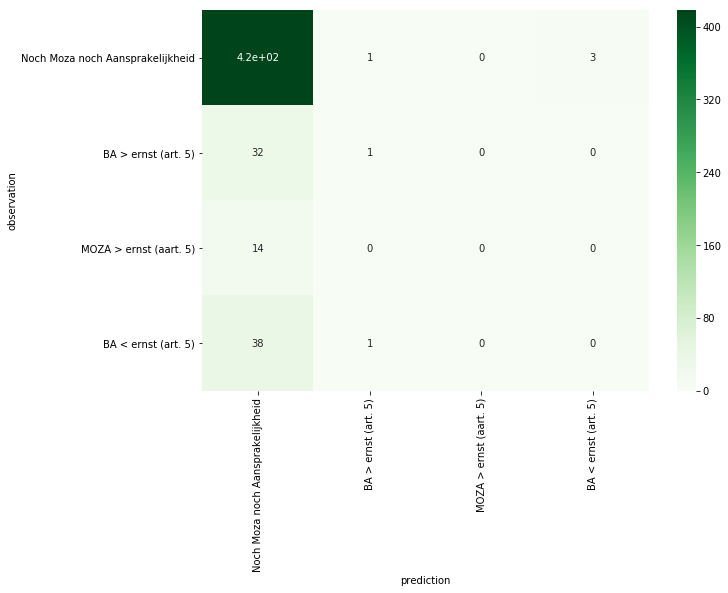

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

df_cm = pd.DataFrame(cm, index = [i for i in range(0, 4)],
                  columns = [i for i in range(0, 4)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Greens", yticklabels=[i for i in mapping.keys()],
            xticklabels=[i for i in mapping.keys()]) #labeling ticks with the previously used mapping dict;)
plt.xlabel("prediction")
plt.ylabel("observation")

plt.show()

In [33]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,7))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


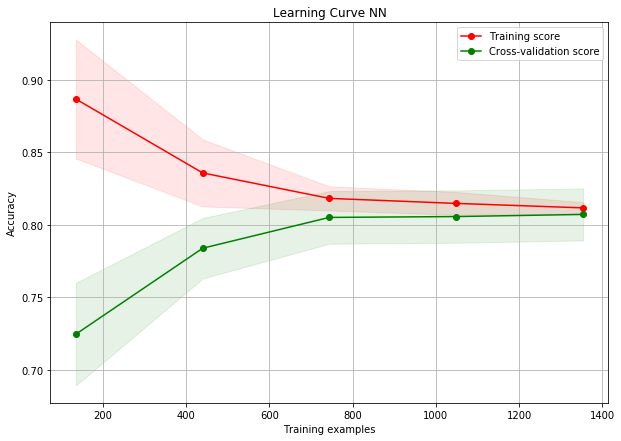

In [34]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(pipe, "Learning Curve NN", X, y, cv=cv)
plt.show()

In [35]:
#high bias -> 3 possibilities :
#increasing number of features (but we are already using all of them)
#decreasing regularization term (alpha is the default 0.0001)
#adding polynomial terms : we will try this one

def add_poly(X, deg):
    '''
    add_poly(df X, int deg) : returns an matrix with each values of X raised to the 2,...,deg power.
    pseudo :
    take a matrix X (size m x n) as input
    calculate each X^i (with i = 2 to deg) and put it in the new columns
    '''
    if deg == 0 :
        raise ValueError("fixing degree to 0 results in all 1's matrix")
    elif deg == 1 :
        return X
    else:
        X_poly = X.copy()
        for i in range(2,deg+1):
            for col in X:
                X_poly[col+"^"+str(i)] = np.power((X[col]), i)
    return X_poly

In [54]:
A = pd.DataFrame({"a" : (1, 1, 1), "b" : (2, 2, 2), "c" :  (3,3,3)})
print(A)
A3 = add_poly(A, 3)
print(A3)

   a  b  c
0  1  2  3
1  1  2  3
2  1  2  3
   a  b  c  a^2  b^2  c^2  a^3  b^3  c^3
0  1  2  3    1    4    9    1    8   27
1  1  2  3    1    4    9    1    8   27
2  1  2  3    1    4    9    1    8   27


In [49]:
X2 = add_poly(X, 4)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3, random_state=42)
#the answer to the universe

pipe = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(6,), solver='lbfgs', max_iter=100))


score = cross_val_score(pipe, X2, y, cv=5)
print("accuracy (CV : 5 folds) : {}".format(score.mean()))

pipe.fit(X2_train, y2_train)
y2_pred = pipe.predict(X2_test)

      ZorgverstrekkersCode  KwalificatiesCode  ActiesCode  FasesCode  \
0                     33.0              190.0      1213.0      333.0   
1                    127.0              190.0      3049.0     3836.0   
2                     31.0              190.0      1926.0     3884.0   
3                     34.0              190.0      3040.0     3801.0   
4                     33.0              190.0      2269.0     3875.0   
5                     34.0              190.0      3027.0      333.0   
6                     30.0              190.0      2960.0      333.0   
7                     30.0              192.0      2863.0     3710.0   
8                     30.0              190.0      2959.0     3884.0   
9                     30.0              190.0      2653.0     3880.0   
10                    30.0              190.0      2906.0      333.0   
11                    30.0              190.0      2921.0     3885.0   
12                    30.0              190.0      2923.0     38

accuracy (CV : 5 folds) : 0.7903641368575498


In [43]:
cm = confusion_matrix(y2_test, y2_pred)
print(cm)

[[412   8   0   2]
 [ 32   1   0   0]
 [ 14   0   0   0]
 [ 37   1   0   1]]


In [10]:
#The true problem here is imbalance -> let's try over-sampling our training sample via SMOTE
#pip install -U imbalanced-learn
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#from-random-over-sampling-to-smote-and-adasyn
from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE().fit_resample(X_train, y_train)

In [46]:
score = cross_val_score(pipe, X_res, y_res, cv=5)
print(score.mean())


pipe.fit(X_res, y_res)
y_pred = pipe.predict(X_test)

print("accuracy (CV : 5 folds) : {}".format(score.mean()))
cm = confusion_matrix(y_test, y_pred)
print(cm)

0.4894736842105263
accuracy (CV : 5 folds) : 0.4894736842105263
[[110  57 116 139]
 [  6   7  12   8]
 [  3   2   4   5]
 [  7   8   8  16]]


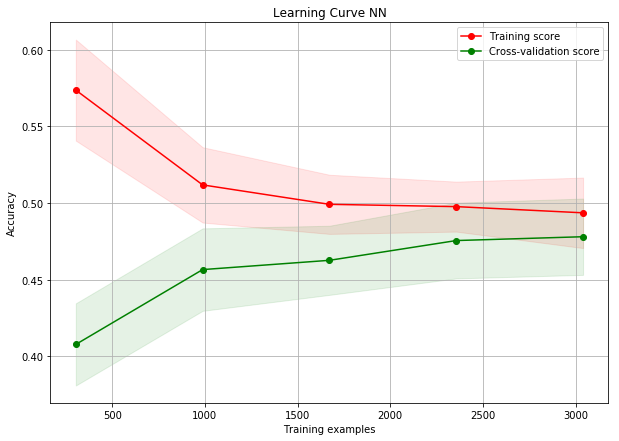

In [47]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(pipe, "Learning Curve NN", X_res, y_res, cv=cv)
plt.show()